# Источник данных

Источник данных: Johns Hopkins CSSE. Исходные данные доступны в [этом репозитории](https://github.com/CSSEGISandData/COVID-19).

Предобработанный одним из кэгглеров датасет и различные варианты прогнозов и визуализация [доступны на платформе Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report). 

Этот ноутбук создан для моих русскоязычных друзей, проживающих в России.

In [1]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
from datetime import datetime
print('Дата обновления этого ноутбука:')
print(datetime.today())

Дата обновления этого ноутбука:
2020-06-05 13:31:28.416007


In [3]:
import pandas as pd
import numpy as np
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for filename in os.listdir():
    if 'time_series' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [4]:
def select_russian_data(data, column_name):
    df = data.copy()
    df = df[df['Country/Region']=='Russia'].reset_index()
    df.drop(columns=['index', 'Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    df = df.T.rename(columns={0: column_name})
    df.index = pd.to_datetime(df.index)
    return df

cases = select_russian_data(pd.read_csv('time_series_covid19_confirmed_global.csv'), 'cases')
deaths = select_russian_data(pd.read_csv('time_series_covid19_deaths_global.csv'), 'deaths')
recovered = select_russian_data(pd.read_csv('time_series_covid19_recovered_global.csv'), 'recovered')

russian_data = cases.merge(deaths, left_index=True, 
                           right_index=True).merge(recovered, left_index=True, right_index=True)

russian_data.index = pd.to_datetime(russian_data.index)
russian_data['cases_a_day'] = russian_data['cases'].diff().fillna(0)

russian_data['is_sick'] = russian_data['cases'] - (russian_data['recovered'] + russian_data['deaths'])
russian_data['lethality'] = russian_data['deaths'] / (russian_data['recovered'] + russian_data['deaths']) 

# Ситуация в Санкт-Петербурге

По данным [официального Штаба](https://t.me/koronavirusspb).

Таблица в гуглдоке поддерживается силами волонтеров.

In [5]:
from io import BytesIO
import requests

from scipy.stats import spearmanr

In [6]:
google_sheet = 'https://docs.google.com/spreadsheets/d/1gHWu8YStECVLw83aiqNOn6IZfHajZgTSJYOQSrVceSU/export#gid=0&format=csv'
raw_data = requests.get(google_sheet).content
spb_df = pd.read_excel(BytesIO(raw_data), index_col=0)                     

spb_df = spb_df.reset_index()
spb_df['date'] = pd.to_datetime(spb_df['date'], dayfirst=True)

# До этой даты есть легкие отличия в формате
spb_df = spb_df[spb_df['date']> pd.to_datetime('05-04-2020', dayfirst=True)]

holidays = list(spb_df[spb_df['date'].dt.weekday.isin([5,6])]['date'].values)
for date in pd.to_datetime(['01-05-2020', '04-05-2020', '05-05-2020', '11-05-2020'], dayfirst=True):
    holidays.append(date)
    
spb_df['is_workday'] = spb_df['date'].apply(lambda x: 0 if x in holidays else 1)

spb_df = spb_df.sort_values('date')

spb_df = spb_df.reset_index().rename(columns={'index': 'day_number_from_start'}).set_index('date')

spb_df['day_number_from_start'] = spb_df['day_number_from_start'][::-1].values + 1

In [7]:
spb_df['new_death'] = spb_df['all_death'].diff(-1)
spb_df['is_sick'] = spb_df['all_cases'] - (spb_df['all_healthy'] + spb_df['all_death'])

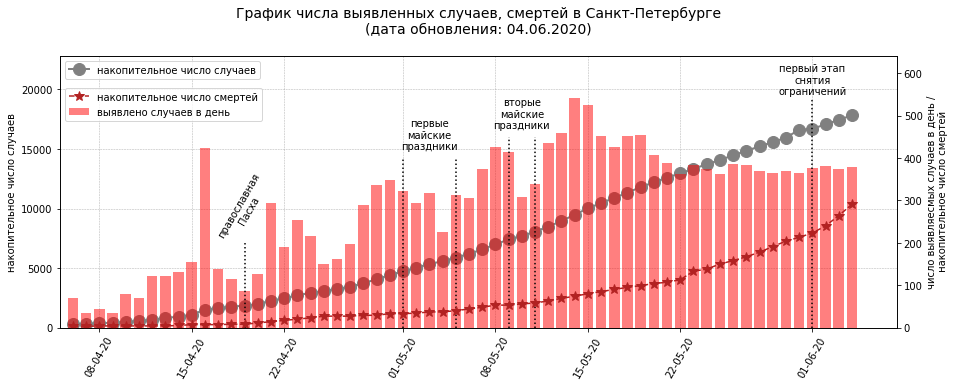

In [8]:
start_date = pd.to_datetime('05-04-2020', dayfirst=True) 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(spb_df['all_cases'], color='grey', marker='o', 
         linewidth=2, markersize=12, label='накопительное число случаев')

ax1.set_ylim(0, spb_df['all_cases'].max()+5000)

# ===== вторая ось ========
ax2 = ax1.twinx()

ax2.text(pd.to_datetime('19-04-2020', dayfirst=True), 
         200,
         'православная\nПасха', 
         fontsize=10, 
         horizontalalignment='center',
         rotation=60)
ax2.vlines(pd.to_datetime('19-04-2020', dayfirst=True), 0, 
           200, 
           linestyle=':')


ax2.vlines(pd.to_datetime('01-05-2020', dayfirst=True), 0, 
           400, 
           linestyle=':')
ax2.text(pd.to_datetime('03-05-2020', dayfirst=True), 
         420,
         'первые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center')
ax2.vlines(pd.to_datetime('05-05-2020', dayfirst=True), 0, 
           400, 
           linestyle=':')

ax2.vlines(pd.to_datetime('09-05-2020', dayfirst=True), 0, 
           450, 
           linestyle=':')
ax2.text(pd.to_datetime('10-05-2020', dayfirst=True), 
         470,
         'вторые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center', 
         rotation=0)
ax2.vlines(pd.to_datetime('11-05-2020', dayfirst=True), 0, 
           450, 
           linestyle=':')

ax2.text(pd.to_datetime('01-06-2020', dayfirst=True), 
         550,
         'первый этап\nснятия\nограничений', 
         fontsize=10, 
         horizontalalignment='center',
         rotation=0)
ax2.vlines(pd.to_datetime('01-06-2020', dayfirst=True), 0, 
           540, 
           linestyle=':')

ax2.plot(spb_df.query('all_death > 0')['all_death'], color='firebrick', marker='*', linestyle='--', 
         markersize=10, label='накопительное число смертей')

ax2.bar(x=spb_df.index, 
        height=spb_df[spb_df.index>=pd.to_datetime('03-28-2020')]['new_cases'], 
        color='red', alpha=0.5, label='выявлено случаев в день')

ax2.set_ylim(0, spb_df['new_cases'].max()+100)

title = '''График числа выявленных случаев, смертей в Санкт-Петербурге
(дата обновления: {:%d.%m.%Y})
'''.format(spb_df.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#ax1.set_ylim(0, russian_data['cases'].max()+30000)
#ax2.set_ylim(0, russian_data['cases_a_day'].max()+1000)
plt.title(title, fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

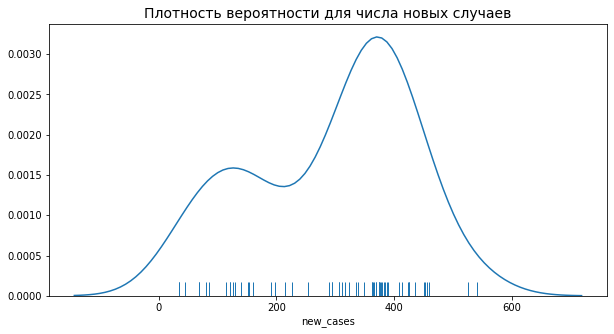

In [9]:
plt.figure(figsize=(10,5))
sns.distplot(spb_df[spb_df.index>=pd.to_datetime('03-28-2020')]['new_cases'],
             rug=True, hist=False)
plt.title('Плотность вероятности для числа новых случаев', fontsize=14)
plt.show()

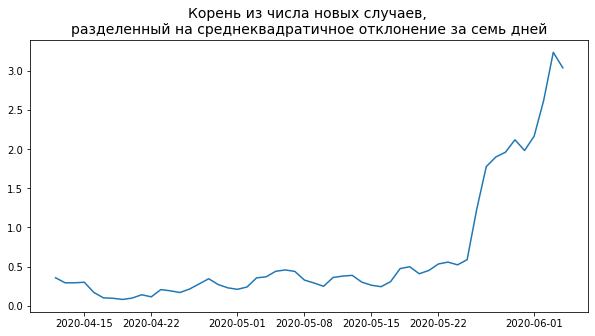

In [32]:
plt.figure(figsize=(10,5))
plt.plot(spb_df['new_cases'].apply(lambda x: np.sqrt(x)) / spb_df['new_cases'].rolling(7).std())
plt.title('Корень из числа новых случаев, \nразделенный на среднеквадратичное отклонение за семь дней', fontsize=14)
plt.show()

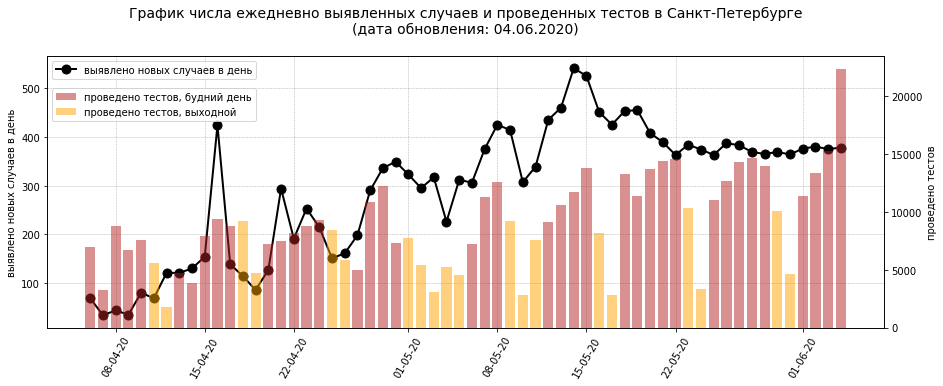

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(spb_df['new_cases'], color='black', marker='o', 
         linewidth=2, markersize=9, label='выявлено новых случаев в день')

# ===== вторая ось ========
ax2 = ax1.twinx()
ax2.bar(x=spb_df.query('is_workday == 1').index, 
        height=spb_df.query('is_workday == 1')['tested'], 
        color='firebrick', alpha=0.5, label='проведено тестов, будний день')
ax2.bar(x=spb_df.query('is_workday == 0').index, 
        height=spb_df.query('is_workday == 0')['tested'], 
        color='orange', alpha=0.5, label='проведено тестов, выходной')

title = '''График числа ежедневно выявленных случаев и проведенных тестов в Санкт-Петербурге
(дата обновления: {:%d.%m.%Y})
'''.format(spb_df.index.max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.title(title, fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('выявлено новых случаев в день')
ax2.set_ylabel('проведено тестов')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

In [12]:
print('=== Корреляция числа выявляемых случаев и проведенных тестов и ежедневного числа смертей ===\n')
for i in range(0, 15):
    sprm = spearmanr(spb_df['new_cases'].shift(i).values, 
              spb_df['tested'].values,
              nan_policy='omit')
    if sprm[1] <= 0.05:
            print(f'Сдвиг числа выявленных случаев covid-19 на {i} дней вперед: {sprm[0]}, p-value {sprm[1]}')

=== Корреляция числа выявляемых случаев и проведенных тестов и ежедневного числа смертей ===

Сдвиг числа выявленных случаев covid-19 на 0 дней вперед: 0.5771806505730861, p-value 1.3823559360881348e-06
Сдвиг числа выявленных случаев covid-19 на 1 дней вперед: 0.5035216432247108, p-value 4.80102270026471e-05
Сдвиг числа выявленных случаев covid-19 на 2 дней вперед: 0.46470705996260553, p-value 0.00023788079505578395
Сдвиг числа выявленных случаев covid-19 на 3 дней вперед: 0.3719837307818048, p-value 0.004382706340216102
Сдвиг числа выявленных случаев covid-19 на 4 дней вперед: 0.3786037781915322, p-value 0.004011465571024906
Сдвиг числа выявленных случаев covid-19 на 5 дней вперед: 0.4330477152998581, p-value 0.0009588867243646963
Сдвиг числа выявленных случаев covid-19 на 6 дней вперед: 0.558876226226838, p-value 1.1219492974540613e-05
Сдвиг числа выявленных случаев covid-19 на 7 дней вперед: 0.571889365620369, p-value 7.702541979316344e-06
Сдвиг числа выявленных случаев covid-19 на 

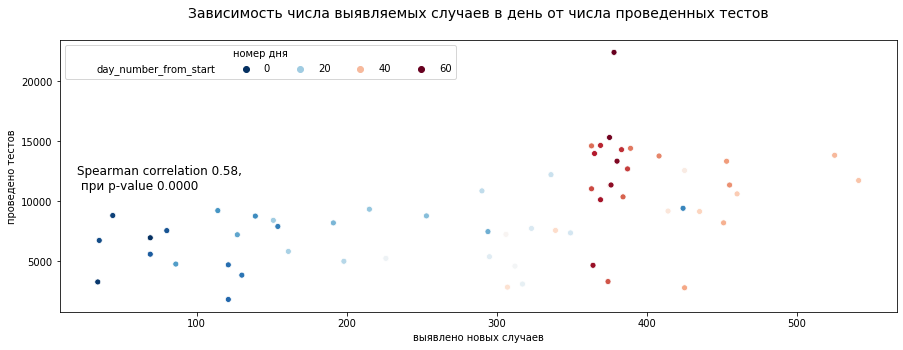

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
sns.scatterplot(data=spb_df, x='new_cases', y='tested', hue="day_number_from_start",
                palette="RdBu_r")
plt.legend(ncol=6, title='номер дня')

sprm = spearmanr(spb_df['tested'].values, 
                 spb_df['new_cases'].values,
                 nan_policy='omit')
plt.text(20, 11000, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)
plt.title('Зависимость числа выявляемых случаев в день от числа проведенных тестов\n', fontsize=14)
plt.xlabel('выявлено новых случаев')
plt.ylabel('проведено тестов')
plt.show()

In [14]:
spb_df['%_of_new_cases_from_tested'] = spb_df['new_cases'] / spb_df['tested']

In [15]:
spb_df.groupby('is_workday')['%_of_new_cases_from_tested'].mean()

is_workday
0    0.056697
1    0.028465
Name: %_of_new_cases_from_tested, dtype: float64

In [16]:
spb_df['%_of_new_cases_from_tested'].describe()

count    60.000000
mean      0.037876
std       0.026860
min       0.004994
25%       0.024195
50%       0.033004
75%       0.043700
max       0.152221
Name: %_of_new_cases_from_tested, dtype: float64

In [17]:
groupbyweek = pd.DataFrame()
groupbyweek['%_of_new_cases_from_tested'] = spb_df.groupby(pd.Grouper(freq='W'))['%_of_new_cases_from_tested'].mean()
groupbyweek['суммарно тестов за неделю'] = spb_df.groupby(pd.Grouper(freq='W'))['tested'].sum().astype(int)
groupbyweek.index = groupbyweek.index.week
groupbyweek = groupbyweek.reset_index().rename(columns={'date': 'номер недели', 
                                                        '%_of_new_cases_from_tested': "процент позитивных"})
groupbyweek['процент позитивных'] = (groupbyweek['процент позитивных'] * 100).round(2)
groupbyweek.set_index('номер недели')

,процент позитивных,суммарно тестов за неделю
номер недели,,
15,1.71,40747
16,2.43,48613
17,2.54,55220
18,4.86,51658
19,5.33,52991
20,6.10,63878
21,4.36,81138
22,3.66,81428
23,2.57,62396


In [18]:
print('=== Корреляция числа выявленных случаев с другими показателями ===\n')

target = 'new_cases'
for column in spb_df.select_dtypes(exclude='object').columns:
    if column not in [target, 'is_workday']:
        sprm = spearmanr(spb_df[column].values, 
                          spb_df[target].values,
                          nan_policy='omit')
        if sprm[1] <= 0.05:
            print(f'{column}: {sprm[0]}, p-value {sprm[1]}')

=== Корреляция числа выявленных случаев с другими показателями ===

day_number_from_start: 0.775585630838448, p-value 3.43105033455335e-13
all_cases: 0.775585630838448, p-value 3.43105033455335e-13
all_death: 0.7747933258107238, p-value 3.755031950748713e-13
all_healthy: 0.7763018963803886, p-value 3.161290937493035e-13
tested: 0.5771806505730861, p-value 1.3823559360881348e-06
quarantined_for_now: -0.47650475258386005, p-value 0.0001187503377478594
quarantined_observation: 0.7052233949366655, p-value 3.161854063918148e-10
new_death: -0.628714477161351, p-value 9.711193051961821e-08
is_sick: 0.7728624252269628, p-value 4.671477941966198e-13
%_of_new_cases_from_tested: 0.5425292485575529, p-value 7.53883118767938e-06


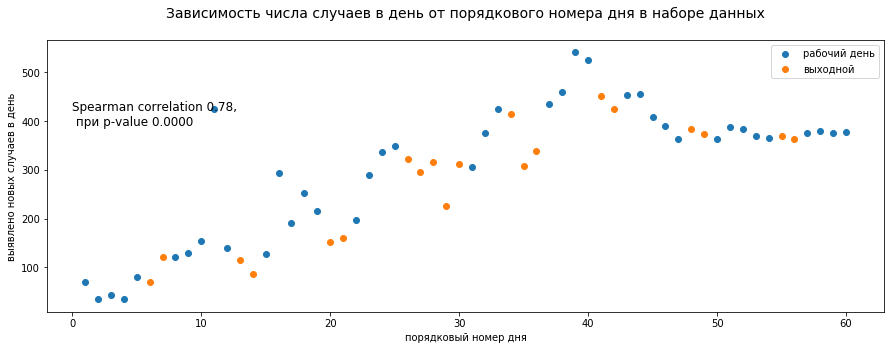

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.scatter(x=spb_df.query('is_workday == 1')['day_number_from_start'],
            y=spb_df.query('is_workday == 1')['new_cases'], label='рабочий день')
plt.scatter(x=spb_df.query('is_workday == 0')['day_number_from_start'],
            y=spb_df.query('is_workday == 0')['new_cases'], label='выходной')


sprm = spearmanr(spb_df['day_number_from_start'].values, 
                 spb_df['new_cases'].values,
                 nan_policy='omit')
plt.text(0, spb_df['new_cases'].max()-150, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)

plt.xlabel('порядковый номер дня')
plt.ylabel('выявлено новых случаев в день')
plt.title('Зависимость числа случаев в день от порядкового номера дня в наборе данных\n', fontsize=14)

plt.legend()
plt.show()

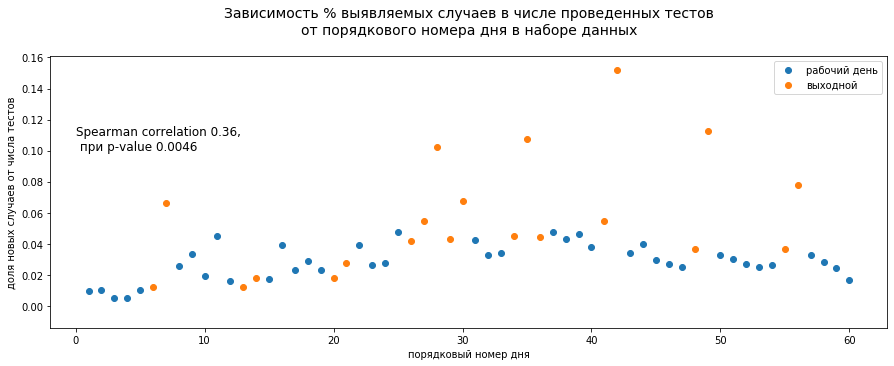

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.scatter(x=spb_df.query('is_workday == 1')['day_number_from_start'],
            y=spb_df.query('is_workday == 1')['%_of_new_cases_from_tested'], label='рабочий день')
plt.scatter(x=spb_df.query('is_workday == 0')['day_number_from_start'],
            y=spb_df.query('is_workday == 0')['%_of_new_cases_from_tested'], label='выходной')

sprm = spearmanr(spb_df['day_number_from_start'].values, 
                 spb_df['%_of_new_cases_from_tested'].values,
                 nan_policy='omit')

plt.xlabel('порядковый номер дня')
plt.ylabel('доля новых случаев от числа тестов')
plt.title('Зависимость % выявляемых случаев в числе проведенных тестов\nот порядкового номера дня в наборе данных\n', fontsize=14)

plt.text(0, 0.1, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)
plt.legend()
plt.show()

In [21]:
print('=== Корреляция числа больных и ежедневного числа смертей ===\n')
for i in range(0, 15):
    sprm = spearmanr(spb_df['new_death'].shift(i).values, 
              spb_df['is_sick'].values,
              nan_policy='omit')
    if sprm[1] <= 0.05:
            print(f'Сдвиг числа умерших от covid-19 на {i} дней вперед: {sprm[0]}, p-value {sprm[1]}')

=== Корреляция числа больных и ежедневного числа смертей ===

Сдвиг числа умерших от covid-19 на 0 дней вперед: -0.8548418759935229, p-value 7.026909989318318e-18
Сдвиг числа умерших от covid-19 на 1 дней вперед: -0.8588932592920705, p-value 3.3223193127403267e-18
Сдвиг числа умерших от covid-19 на 2 дней вперед: -0.849943597727414, p-value 3.230344232305656e-17
Сдвиг числа умерших от covid-19 на 3 дней вперед: -0.8493877235848261, p-value 6.795367750534288e-17
Сдвиг числа умерших от covid-19 на 4 дней вперед: -0.8358285543666791, p-value 1.1087470900541636e-15
Сдвиг числа умерших от covid-19 на 5 дней вперед: -0.8209396123905575, p-value 1.667319432077037e-14
Сдвиг числа умерших от covid-19 на 6 дней вперед: -0.8211648521610931, p-value 2.860693033293486e-14
Сдвиг числа умерших от covid-19 на 7 дней вперед: -0.809599949469976, p-value 2.1548240494025937e-13
Сдвиг числа умерших от covid-19 на 8 дней вперед: -0.8028579237720453, p-value 8.122168356260701e-13
Сдвиг числа умерших от covid

**Летальность** рассчитывается от числа разрешившихся случаев. Считать ее от «общего числа случаев» неверно с точки зрения сравнения данных (так как не известно, как разрешатся случаи, которые еще «в процессе»).

In [22]:
spb_df['lethality'] = spb_df['all_death'] / (spb_df['all_healthy'] + spb_df['all_death']) 
spb_df['lethality'].describe()

count    60.000000
mean      0.039213
std       0.010619
min       0.023952
25%       0.032785
50%       0.036394
75%       0.042126
max       0.076923
Name: lethality, dtype: float64

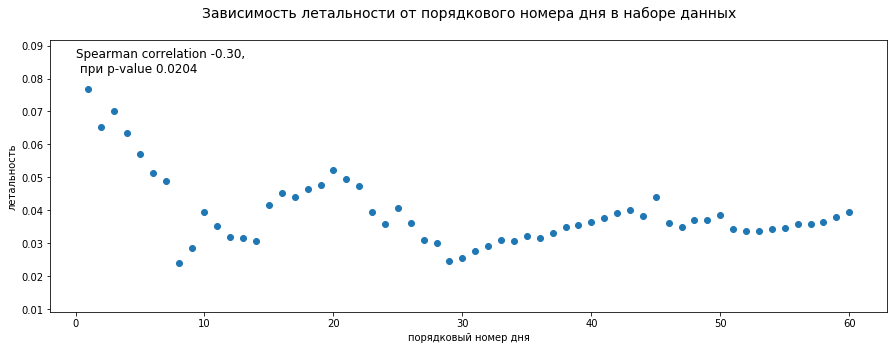

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.scatter(x=spb_df['day_number_from_start'],
            y=spb_df['lethality'])
sprm = spearmanr(spb_df['day_number_from_start'].values, 
                 spb_df['lethality'].values,
                 nan_policy='omit')

plt.xlabel('порядковый номер дня')
plt.ylabel('летальность')
plt.title('Зависимость летальности от порядкового номера дня в наборе данных\n', fontsize=14)

plt.text(0, spb_df['lethality'].max()+0.005, f'Spearman correlation {sprm[0]:.2f},\n при p-value {sprm[1]:.4f}',
         fontsize=12)
plt.show()

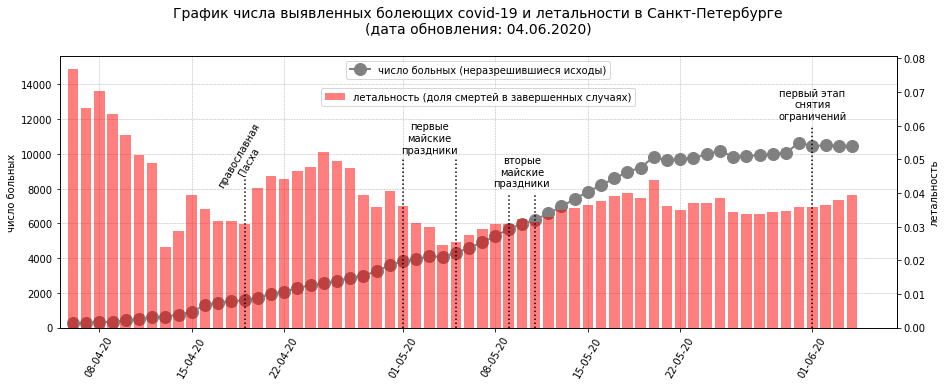

In [24]:
start_date = pd.to_datetime('05-04-2020', dayfirst=True) 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(spb_df['is_sick'], color='grey', marker='o', 
         linewidth=2, markersize=12, label='число больных (неразрешившиеся исходы)')

ax1.set_ylim(0, spb_df['is_sick'].max()+5000)

# ===== вторая ось ========
ax2 = ax1.twinx()

ax2.text(pd.to_datetime('19-04-2020', dayfirst=True), 
         0.04,
         'православная\nПасха', 
         fontsize=10, 
         horizontalalignment='center',
         rotation=60)
ax2.vlines(pd.to_datetime('19-04-2020', dayfirst=True), 0, 
           0.045, 
           linestyle=':')


ax2.vlines(pd.to_datetime('01-05-2020', dayfirst=True), 0, 
           0.05, 
           linestyle=':')
ax2.text(pd.to_datetime('03-05-2020', dayfirst=True), 
         0.052,
         'первые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center')
ax2.vlines(pd.to_datetime('05-05-2020', dayfirst=True), 0, 
           0.05, 
           linestyle=':')

ax2.vlines(pd.to_datetime('09-05-2020', dayfirst=True), 0, 
           0.04, 
           linestyle=':')
ax2.text(pd.to_datetime('10-05-2020', dayfirst=True), 
         0.042,
         'вторые\nмайские\nпраздники', 
         fontsize=10, 
         horizontalalignment='center', 
         rotation=0)
ax2.vlines(pd.to_datetime('11-05-2020', dayfirst=True), 0, 
           0.04, 
           linestyle=':')

ax2.text(pd.to_datetime('01-06-2020', dayfirst=True), 
         0.062,
         'первый этап\nснятия\nограничений', 
         fontsize=10, 
         horizontalalignment='center',
         rotation=0)
ax2.vlines(pd.to_datetime('01-06-2020', dayfirst=True), 0, 
           0.06, 
           linestyle=':')



ax2.bar(x=spb_df.index, 
        height=spb_df['lethality'], 
        color='red', alpha=0.5, label='летальность (доля смертей в завершенных случаях)')

title = '''График числа выявленных болеющих covid-19 и летальности в Санкт-Петербурге
(дата обновления: {:%d.%m.%Y})
'''.format(spb_df.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#ax1.set_ylim(0, russian_data['cases'].max()+30000)
#ax2.set_ylim(0, russian_data['cases_a_day'].max()+1000)
plt.title(title, fontsize=14)
ax1.legend(loc='upper center')
ax2.legend(loc='upper center', bbox_to_anchor=(0.25, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('число больных')
ax2.set_ylabel('летальность')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

# Сравнение со всей Россией

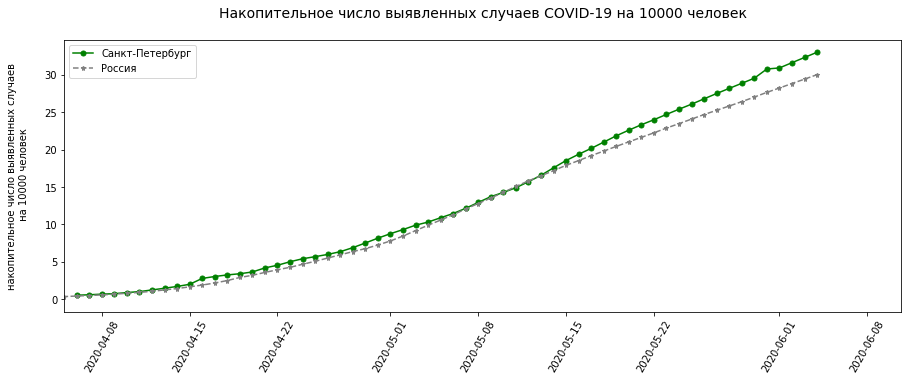

In [25]:
n = 10000

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

plt.plot(spb_df['all_cases'] / 5398064 * n, color='green', 
         marker='o', linestyle='-', markersize=5, label='Санкт-Петербург')

plt.plot(russian_data['cases'] / 146748590 * n, color='grey', 
         marker='*', linestyle='--', markersize=5, label='Россия')
plt.title(f'Накопительное число выявленных случаев COVID-19 на {n} человек\n', fontsize=14)
plt.xlim(start_date)
plt.ylabel(f'накопительное число выявленных случаев\n на {n} человек\n')
plt.legend()
plt.show()

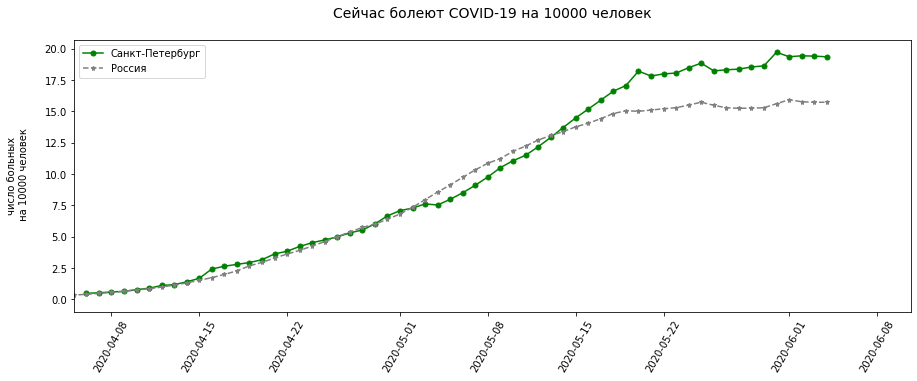

In [26]:
n = 10000

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

plt.plot(spb_df['is_sick'] / 5398064 * n, color='green', 
         marker='o', linestyle='-', markersize=5, label='Санкт-Петербург')

plt.plot(russian_data['is_sick'] / 146748590 * n, color='grey', 
         marker='*', linestyle='--', markersize=5, label='Россия')
plt.title(f'Сейчас болеют COVID-19 на {n} человек\n', fontsize=14)
plt.xlim(start_date)
plt.ylabel(f'число больных\n на {n} человек\n')
plt.legend()
plt.show()

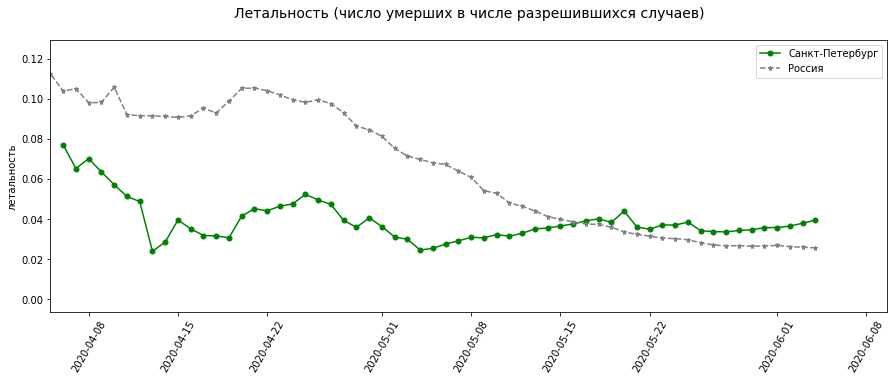

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

plt.plot(spb_df['lethality'], color='green', 
         marker='o', linestyle='-', markersize=5, label='Санкт-Петербург')

plt.plot(russian_data['lethality'], color='grey', 
         marker='*', linestyle='--', markersize=5, label='Россия')
plt.title(f'Летальность (число умерших в числе разрешившихся случаев)\n', fontsize=14)
plt.xlim(start_date)
plt.ylabel(f'летальность')
plt.legend()
plt.show()

# Варианты прокси-показателей развития эпидемии

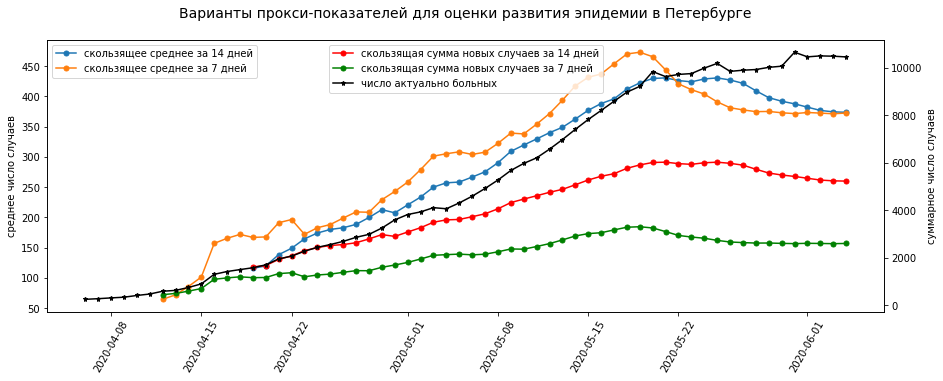

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(spb_df['new_cases'].rolling(14).mean(), marker='o', markersize=5,
         label='скользящее среднее за 14 дней')
ax1.plot(spb_df['new_cases'].rolling(7).mean(), marker='o', markersize=5,
         label='скользящее среднее за 7 дней')

# ===== вторая ось ========
ax2 = ax1.twinx()
ax2.plot(spb_df['new_cases'].rolling(14).sum(), marker='o', markersize=5,
         label='скользящая сумма новых случаев за 14 дней', color='red')
ax2.plot(spb_df['new_cases'].rolling(7).sum(), marker='o', markersize=5,
         label='скользящая сумма новых случаев за 7 дней', color='green')
ax2.plot(spb_df['is_sick'], marker='*', markersize=5,
         label='число актуально больных', color='black')

ax1.set_ylabel('среднее число случаев')
ax2.set_ylabel('суммарное число случаев')
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')

plt.title('Варианты прокси-показателей для оценки развития эпидемии в Петербурге\n', fontsize=14)
plt.show()

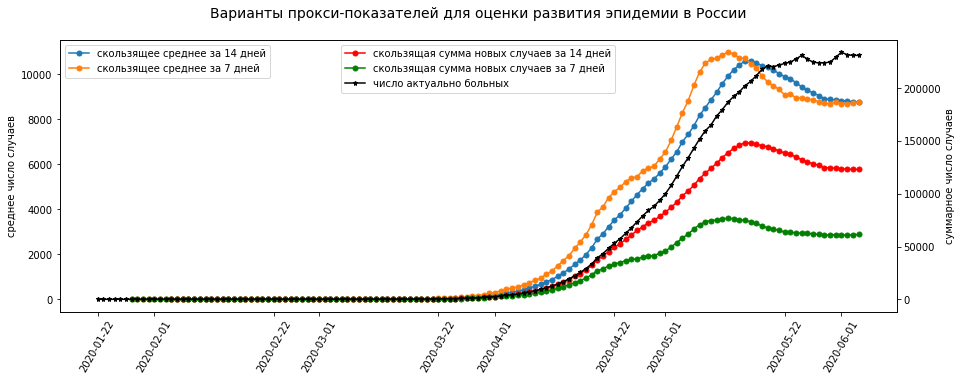

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(russian_data['cases_a_day'].rolling(14).mean(), marker='o', markersize=5,
         label='скользящее среднее за 14 дней')
ax1.plot(russian_data['cases_a_day'].rolling(7).mean(), marker='o', markersize=5,
         label='скользящее среднее за 7 дней')
#ax1.plot(russian_data['cases_a_day'].rolling(14).median(), marker='o', markersize=5,
#         label='скользящая медиана за 14 дней')
#ax1.plot(russian_data['cases_a_day'].rolling(7).median(), marker='o', markersize=5,
#         label='скользящая медиана за 7 дней')

# ===== вторая ось ========
ax2 = ax1.twinx()
ax2.plot(russian_data['cases_a_day'].rolling(14).sum(), marker='o', markersize=5,
         label='скользящая сумма новых случаев за 14 дней', color='red')
ax2.plot(russian_data['cases_a_day'].rolling(7).sum(), marker='o', markersize=5,
         label='скользящая сумма новых случаев за 7 дней', color='green')
ax2.plot(russian_data['is_sick'], marker='*', markersize=5,
         label='число актуально больных', color='black')

ax1.set_ylabel('среднее число случаев')
ax2.set_ylabel('суммарное число случаев')
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
plt.title('Варианты прокси-показателей для оценки развития эпидемии в России\n', fontsize=14)
plt.show()